In [ ]:
!pip install uproot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import uproot
import pandas as pd

# Generate toy data

New Physics model 'NP1' is Gaussian (0,1), SM is Gaussian (0.5,1)

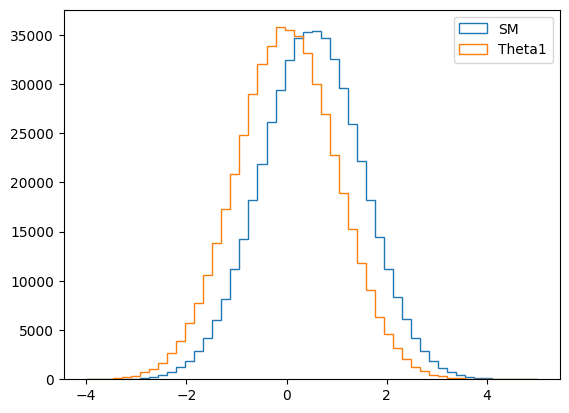

In [2]:
nEvents = 10**6
gTheta1 = (0,1)
gSM = (0.5,1)

X = np.concatenate([np.random.normal(loc=gTheta1[0],scale=gTheta1[1], size=nEvents//2), 
     np.random.normal(loc=gSM[0],scale=gSM[1], size=nEvents//2)])
Y = np.concatenate([np.ones(nEvents//2), np.zeros(nEvents//2)])

plt.hist(X[Y==0], bins=50, histtype="step", range=(-4,5), label="SM")
plt.hist(X[Y==1], bins=50, histtype="step", range=(-4,5), label="Theta1")
plt.legend()
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X.reshape(-1,1) ,Y, train_size=nEvents//2, shuffle=True)

# Define likelihood ratio estimators

In [ ]:
write mathematical formula

In [4]:
class trueLR:
    def predict(self, X):
        from scipy.stats import multivariate_normal
        rv_theta1 = multivariate_normal((gTheta1[0]),(gTheta1[1])).pdf
        rv_SM = multivariate_normal((gSM[0]),(gSM[1])).pdf
        LR = rv_theta1(X)/rv_SM(X)                             
        #LR = rv_SM(X) / rv_theta1(X)                            
        return LR
trueLR_model = trueLR()

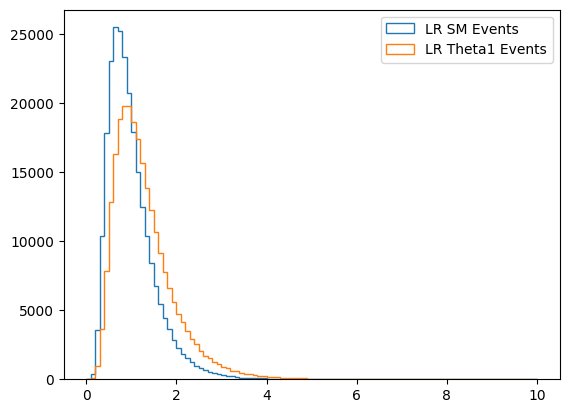

In [5]:
LR_SM_test = trueLR_model.predict(X=X_test[Y_test==0])
LR_theta1_test = trueLR_model.predict(X=X_test[Y_test==1])

plt.hist(LR_SM_test,
         bins=100, histtype="step", range=(0,10), label="LR SM Events")
plt.hist(LR_theta1_test,
         bins=100, histtype="step", range=(0,10), label="LR Theta1 Events")
plt.legend()
plt.show()

In [6]:
print ("Combined LR SM: ",LR_SM_test.prod(), "Combined LR NP: ", LR_theta1_test.prod())
print ("Rreducing stats to only 100 events")
print ("Combined LR back: ",LR_SM_test[:100].prod(), "Combined LR signal: ", LR_theta1_test[:100].prod())

Combined LR SM:  0.0 Combined LR NP:  inf
Rreducing stats to only 100 events
Combined LR back:  8.050286037498369e-06 Combined LR signal:  345372.00184932776


/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/numpy/core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


# Assume you expect to observe only 10 events in data

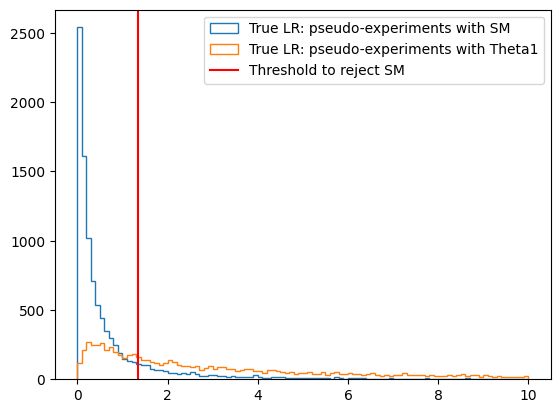

In [7]:
nData = 10
nPseudoExp = 10**4
dataset_LR_SM = LR_SM_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)
dataset_LR_theta1 = LR_theta1_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)

plt.hist(dataset_LR_SM,
         bins=100, histtype="step", range=(0,10), label="True LR: pseudo-experiments with SM")
plt.hist(dataset_LR_theta1,
         bins=100, histtype="step", range=(0,10), label="True LR: pseudo-experiments with Theta1")
threshold = 1.35
plt.axvline(x = threshold, color = 'r', label = 'Threshold to reject SM')
plt.legend()
plt.show()

In [8]:
(dataset_LR_SM > threshold).sum() / dataset_LR_SM.shape[0], (dataset_LR_theta1 > threshold).sum() / dataset_LR_theta1.shape[0]

(0.1608, 0.7243)

# How to get this in a "Likelihood-Free" way ?

In [9]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train.shape[1],))
D = Dense(256, activation="relu")(inputs) # first layer
D = Dense(256, activation="relu")(D) 
D = Dense(1, activation="sigmoid")(D) # last layer
clf = Model(inputs=inputs, outputs=D)

clf.compile(loss="binary_crossentropy", optimizer="adam")

In [10]:
clf.fit(x=X_train, y=Y_train, epochs=10, batch_size=1024)

Epoch 1/10
489/489 [==============================] - 2s 2ms/step - loss: 0.6633
Epoch 2/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 3/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 4/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 5/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 6/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 7/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 8/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 9/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 10/10
489/489 [==============================] - 1s 2ms/step - loss: 0.6630


In [9]:
# Overtrained classifier example

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(X_train.shape[1],))
D = Dense(256, activation="linear")(inputs) # first layer
D = Dense(256, activation="linear")(D) 
D = Dense(1, activation="linear")(D) # last layer
clf = Model(inputs=inputs, outputs=D)

clf.compile(loss="binary_crossentropy", optimizer="adam")

clf.fit(x=X_train[:100], y=Y_train[:100], epochs=10, batch_size=1)

Epoch 1/10
100/100 [==============================] - 2s 2ms/step - loss: 4.6407
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 5.2646
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 5.3766
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 8.1772
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 7.7919
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 8.5033
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 8.1582
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 8.1586
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 8.1587
Epoch 10/10
100/100 [==============================] - 0s 1ms/step - loss: 8.1617


In [10]:
y_pred = clf.predict(X_test, batch_size=4*1024).ravel()

123/123 [==============================] - 0s 967us/step


In [11]:
lr_pred = y_pred/(1-y_pred)

In [12]:
LR_pred_SM_test = lr_pred[Y_test==0]
LR_pred_theta1_test = lr_pred[Y_test==1]

In [13]:
print("SM data")
print ("True LR: ", LR_SM_test[:5], "\nPred LR: ", LR_pred_SM_test[:5])
print("Theta1 data")
print ("True LR: ", LR_theta1_test[:5], "\nPred LR: ", LR_pred_theta1_test[:5])


SM data
True LR:  [0.76550343 0.79156015 0.8107669  0.85125546 0.98666081] 
Pred LR:  [-1.2852333 -1.3156472 -1.341694  -1.4106766 -2.056802 ]
Theta1 data
True LR:  [0.99475381 1.13456899 1.10287128 1.68307935 1.84885756] 
Pred LR:  [-2.1575963   1.162235    4.658544   -0.77477354 -0.8143852 ]


# Uses: 
- Simulation-Based inference
- Negative weighted events: reweight MC with negative weights into MC with only positive weights
- Re-weighing
- Unfolding

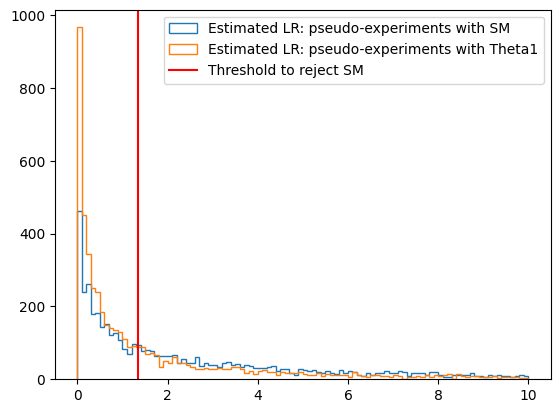

In [14]:
nData = 10
nPseudoExp = 10**4
dataset_LR_pred_SM = LR_pred_SM_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)
dataset_LR_pred_theta1 = LR_pred_theta1_test[:nPseudoExp*nData].reshape(nData,-1).prod(axis=0)

plt.hist(dataset_LR_pred_SM,
         bins=100, histtype="step", range=(0,10), label="Estimated LR: pseudo-experiments with SM")
plt.hist(dataset_LR_pred_theta1,
         bins=100, histtype="step", range=(0,10), label="Estimated LR: pseudo-experiments with Theta1")
threshold = 1.35
plt.axvline(x = threshold, color = 'r', label = 'Threshold to reject SM')
plt.legend()
plt.show()

## Diagnostics: Re-weighting SM events to look like Theta1

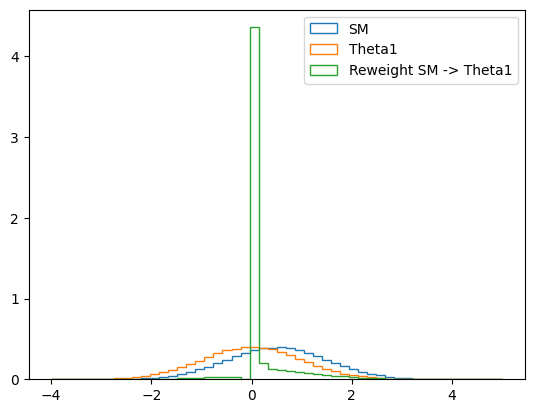

In [15]:
weights = lr_pred

plt.hist(X_test[Y_test==0], bins=50, histtype="step", density=1, range=(-4,5), label="SM")
plt.hist(X_test[Y_test==1], bins=50, histtype="step", density=1, range=(-4,5), label="Theta1")
plt.hist(X_test[Y_test==0], weights=weights[Y_test==0], bins=50, histtype="step", density=1, range=(-4,5), label="Reweight SM -> Theta1")
plt.legend()
plt.show()

## Diagnostics: Calibration curve

In [ ]:
y_pred_train = clf.predict(X_train, batch_size=4*1024).ravel()

In [ ]:
define pruity here
make a better overtrained classifeir

In [16]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(Y_test, y_pred, n_bins=50)
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.plot(prob_true, prob_pred, marker='.', label='clf test')
# prob_true, prob_pred = calibration_curve(Y_train, y_pred_train, n_bins=50)
# plt.plot(prob_true, prob_pred, marker='.', label='clf train')
plt.legend()
plt.xlabel("True purity")
plt.ylabel("Predicted purity")
plt.show()

ValueError: y_prob has values outside [0, 1].

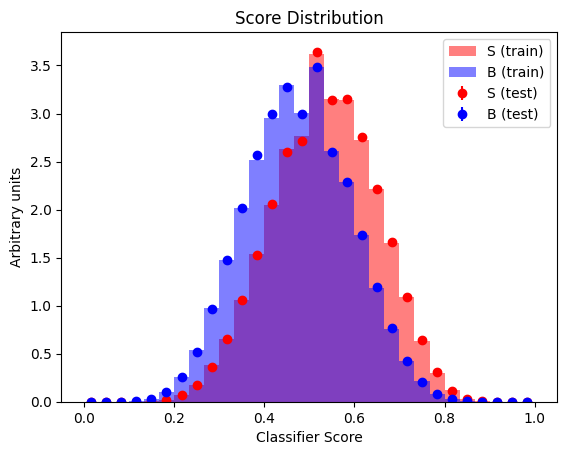

In [20]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train,
    Y_train,
    y_pred,
    Y_test,
    xlabel="Classifier Score",
    title="Score Distribution",
)

## Exercise:
- Try plots with a poorly trained classifier

## Optional:
- Try 2D Gaussian models for SM and theta1

# Now on physics dataset

In [ ]:
make it b vs s+b

In [80]:
# same data & data loading code as S vs B tutorial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filename = "dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())
print(file.keys())

tree = file["tree_event"]  # select the TTree inside the root file
tree.show()  # show all the branches inside the TTree
dfall = tree.arrays(library="pd")  # convert uproot TTree into pandas dataframe
print("============================================")
print("File loaded with ", len(dfall), " events ")

label_weights = (dfall[dfall.label == 0].mcWeight.sum(), dfall[dfall.label == 1].mcWeight.sum())
print("total label weights", label_weights)

label_nevents = (len(dfall[dfall.label == 0]), len(dfall[dfall.label == 1]))
print("total class number of events", label_nevents)

print("Number of events before selections:", len(dfall))
fulldata = dfall[
    (dfall.lep_n == 2) & (dfall.mcWeight > 0)
]  # only keep events with exactly two leptons and positive event weights
print("Number of events after selections:", len(fulldata))

target = fulldata["label"]
weights = fulldata["mcWeight"]

true_class_weights = [weights[target == 0].sum(), weights[target == 1].sum()]

#data = pd.DataFrame(fulldata, columns=["met_et", "met_phi", "lep_pt_0", "lep_pt_1", 'lep_phi_0', 'lep_phi_1'])
data = pd.DataFrame(fulldata, columns=['met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1'])

train_size = 0.75  # fraction of sample used for training

XP_train, XP_test, yP_train, yP_test, weightsP_train, weightsP_test = train_test_split(
    data, target, weights, train_size=train_size
)

y_trainP, y_testP, weights_trainP, weights_testP = (
    yP_train.reset_index(drop=True),
    yP_test.reset_index(drop=True),
    weightsP_train.reset_index(drop=True),
    weightsP_test.reset_index(drop=True),
)


(
    XP_test,
    XP_val,
    yP_test,
    yP_val,
    weightsP_test,
    weightsP_val,
) = train_test_split(XP_test, yP_test, weightsP_test, train_size=0.5, shuffle=False)

{'tree_event;1': 'TTree'}
['tree_event;1']
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0        

In [81]:
XP_train.shape

(433017, 24)

In [82]:
prec = 2

scalerP = StandardScaler()
XP_train = scalerP.fit_transform(XP_train)
XP_val = scalerP.transform(XP_val)
XP_test = scalerP.transform(XP_test)

class_weights_train = (weightsP_train[yP_train == 0].sum(), weightsP_train[yP_train == 1].sum())

print("true_class_weights for (bkg, sig):", true_class_weights)

for i in range(len(class_weights_train)):
    weightsP_train[yP_train == i] *= (
        max(class_weights_train) / class_weights_train[i]
    )  # equalize number of background and signal event

    weightsP_val[yP_val == i] *= max(class_weights_train) / class_weights_train[i]  # likewise for validation and test sets

    weightsP_test[yP_test == i] *= (
        true_class_weights[i] / weights_test[y_test == i].sum()
    )  # increase test weight to compensate for sampling


true_class_weights for (bkg, sig): [159.68849189959997, 6.179398249600003]


In [124]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(XP_train.shape[1],))
C = Dense(1024, activation="relu")(inputs) # first layer
C = Dense(1024, activation="relu")(C) 
C = Dense(1, activation="sigmoid")(C) # last layer
model = Model(inputs=inputs, outputs=C)

model.compile(loss="binary_crossentropy", optimizer="adam")

In [125]:
model.fit(x=XP_train, y=yP_train, epochs=10, batch_size=1024)

Epoch 1/10
423/423 [==============================] - 1s 2ms/step - loss: 0.3642
Epoch 2/10
423/423 [==============================] - 1s 2ms/step - loss: 0.3046
Epoch 3/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2897
Epoch 4/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2832
Epoch 5/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2787
Epoch 6/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2763
Epoch 7/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2736
Epoch 8/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2716
Epoch 9/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2697
Epoch 10/10
423/423 [==============================] - 1s 2ms/step - loss: 0.2673


In [126]:
yP_pred = model.predict(XP_test, batch_size=4*1024).ravel()
yP_train_pred = model.predict(XP_train, batch_size=4*1024).ravel()
lrP_pred = yP_pred/(1-yP_pred)

106/106 [==============================] - 0s 1ms/step


## Typical plots

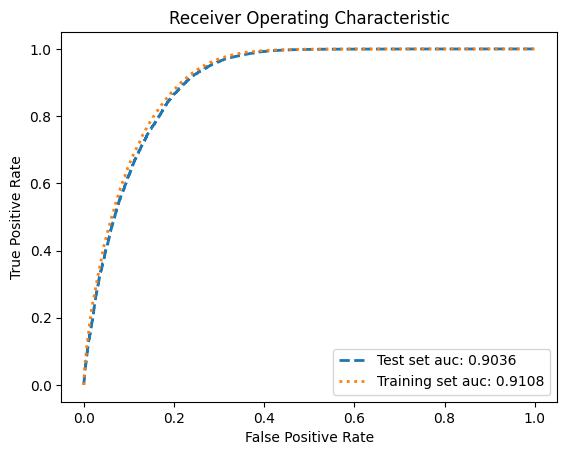

In [131]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=yP_test, y_score=yP_pred, sample_weight=weightsP_test)
fpr_train, tpr_train, _ = roc_curve(y_true=yP_train, y_score=yP_train_pred, sample_weight=weightsP_train)
auc_test = roc_auc_score(y_true=yP_test, y_score=yP_pred, sample_weight=weightsP_test)
auc_train = roc_auc_score(y_true=yP_train.values, y_score=yP_train_pred, sample_weight=weightsP_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

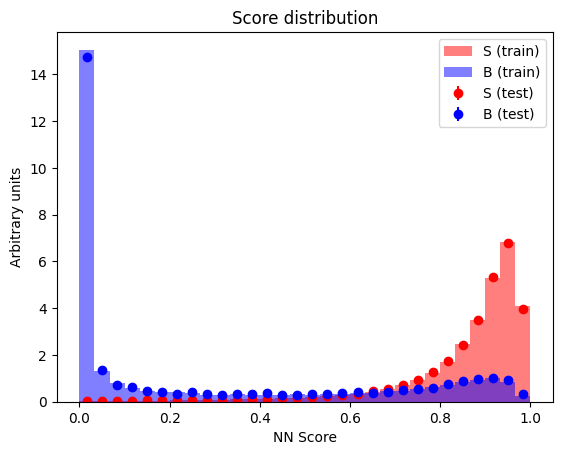

In [138]:
from extra_functions import compare_train_test

compare_train_test(
    yP_train_pred,
    yP_train,
    yP_pred,
    yP_test,
    xlabel="NN Score",
    title="Score distribution",
    weights_train=weightsP_train.values,
    weights_test=weightsP_test.values,
)

## Advanced Diagnostics

In [ ]:
axis labels

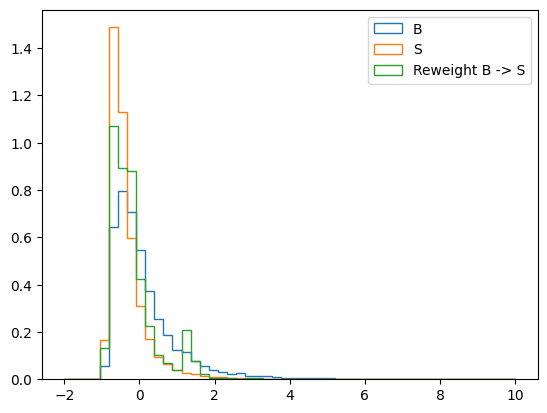

In [139]:
reweights = weightsP_test * lrP_pred
f = 3; rangee = (-2,10)  # which observable to plot, what range
plt.hist(XP_test[yP_test==0, f], weights=weightsP_test[yP_test==0], 
         bins=50, range=rangee, histtype="step", density=1, label="B")
plt.hist(XP_test[yP_test==1, f], weights=weightsP_test[yP_test==1], 
         bins=50, range=rangee, histtype="step", density=1, label="S")
plt.hist(XP_test[yP_test==0, f], weights=reweights[yP_test==0], 
         bins=50, range=rangee, histtype="step", density=1, label="Reweight B -> S")
plt.legend()
plt.show()

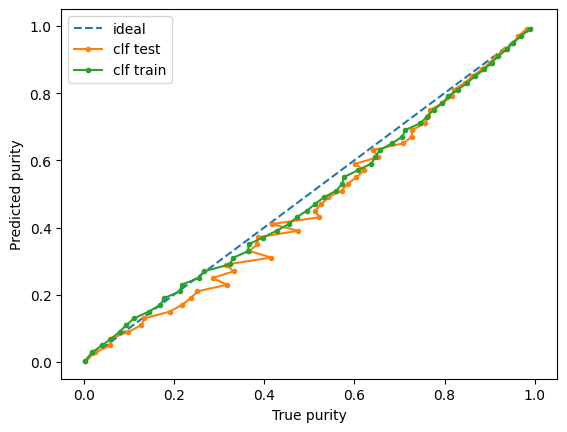

In [140]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(yP_test, yP_pred, n_bins=50)
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.plot(prob_true, prob_pred, marker='.', label='clf test')
prob_true, prob_pred = calibration_curve(yP_train, yP_train_pred, n_bins=50)
plt.plot(prob_true, prob_pred, marker='.', label='clf train')
plt.legend()
plt.xlabel("True purity")
plt.ylabel("Predicted purity")
plt.show()

## Exercise:
- How can we improve the performance? Preprocessing & HPO, regularization (dropouts), early-stopping
- Ensembling

## Optional:
- Investigate phase space with poor performance

# Omnifold: Multi-dimensional unbinned unfolding
Content borrowed from Vinicius Mikuni (https://github.com/usatlas-ml-training/lbnl-2023/blob/main/unfolding/DIS_Omnifold-sol.ipynb)

In [145]:
import omnifold as of

In [141]:
N_Events = 10**5

# Synthetic
theta0_G = np.random.normal(0.2, 0.8, N_Events)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

# Natural
theta_unknown_G = np.random.normal(0, 1, N_Events)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G])

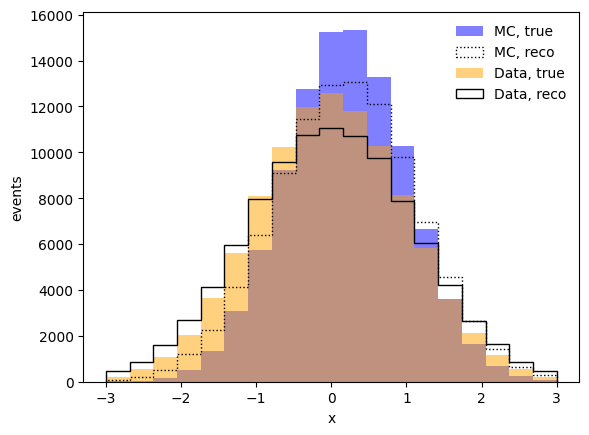

In [142]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta0_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', ls=':', label="MC, reco")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(theta_unknown_S, bins=np.linspace(-3, 3, 20), histtype="step", color='black', label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Define the Model Architecture

In [143]:
inputs = Input((1,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model_gaus = Model(inputs=inputs, outputs=outputs)

In [146]:
N_Iterations = 2
myweights = of.omnifold(theta0_G, theta0_S, theta_unknown_S, N_Iterations, model_gaus)


ITERATION: 1

STEP 1

10/10 [==============================] - 0s 1ms/step

STEP 2

10/10 [==============================] - 0s 1ms/step

ITERATION: 2

STEP 1

10/10 [==============================] - 0s 1ms/step

STEP 2

10/10 [==============================] - 0s 1ms/step


### Plot unfolded distributions

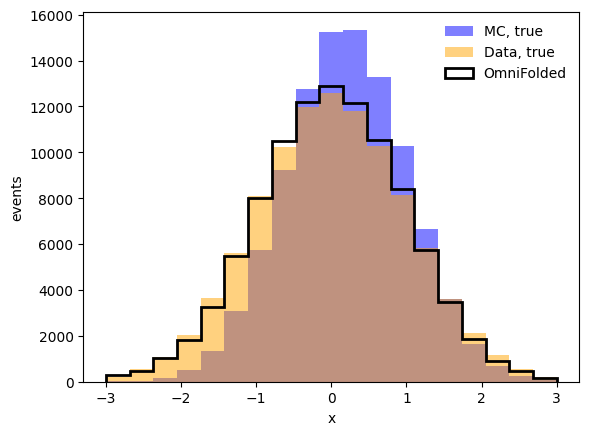

In [147]:
_, _, _ = plt.hist(theta0_G, bins=np.linspace(-3, 3, 20), color='blue', alpha=0.5, label="MC, true")
_, _, _ = plt.hist(theta_unknown_G, bins=np.linspace(-3, 3, 20), color='orange', alpha=0.5, label="Data, true")
_, _, _ = plt.hist(
    theta0_G,
    weights=myweights[-1, 1, :],
    bins=np.linspace(-3, 3, 20),
    color='black',
    histtype="step",
    label="OmniFolded",
    lw=2,
)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

### Plot the distribution at reco level instead of gen level

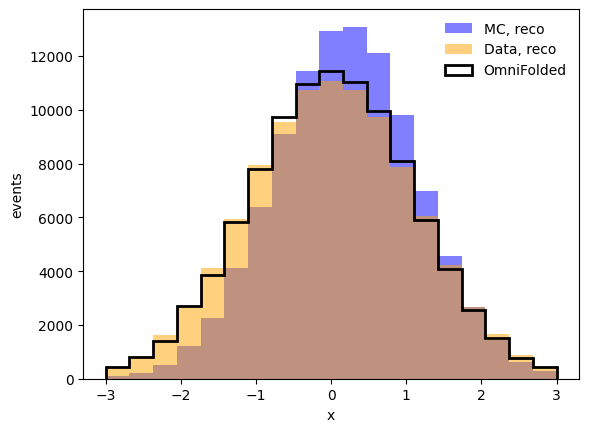

In [149]:
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, reco")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, reco")
_,_,_=plt.hist(theta0_S,weights=myweights[-1, 1, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw=2)
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [ ]:
include dis